Projections. I was given 1800 raw projections of the battery, and in this notebook I convert them into a visualizable format, draw statstics, and save as npy. Question: *can sax-nerf reconstruct the 3D volume starting from such data?*

In [1]:
import numpy as np
from PIL import Image
import glob
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

# Set parameters
input_folder = 'data/raw/021'
output_folder = 'data/jpg/021_sinograms'
width, height = 1024, 1024
new_size = (256, 256)  # Target size for resizing
dtype = np.float32  # 32-bit float



## Load raw data

Simply load raw data and draw statistics.

In [7]:
# Collect paths for all .raw files in the folder
file_paths = sorted(glob.glob(os.path.join(input_folder, '*.raw')))
projections = []
step = 10

for idx, file_path in enumerate(tqdm(file_paths)):
    if idx % step == 0:
        # Load raw image data
        img_data = np.fromfile(file_path, dtype=dtype)
        img_data = img_data.newbyteorder('L')           # Ensures little-endian
        img_data = img_data.reshape((height, width))    # Reshape to original dimensions
        projections.append(np.array(img_data))       # Append to list as numpy array

projections = np.array(projections)
num_images, height, width = projections.shape
print(f'{num_images} images collected with shape ({height}, {width})')

100%|██████████| 1800/1800 [00:00<00:00, 4501.14it/s]


180 images collected with shape (1024, 1024)


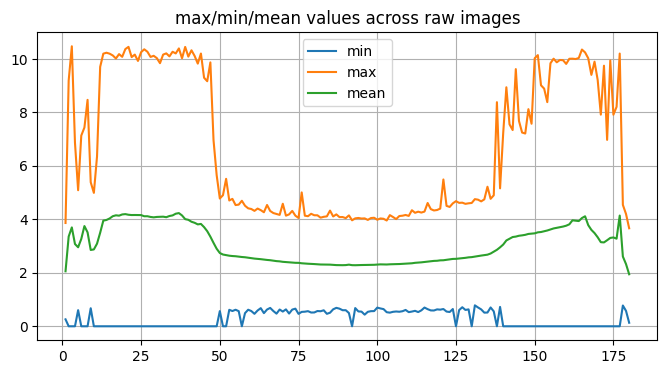

In [8]:
def plot_statistics(projections, title):
    num_images = projections.shape[0]
    x_values = np.arange(1, num_images+1)
    min_values = []
    max_values = []
    mean_values = []

    for i in range(num_images):
        min_values.append(np.min(projections[i]))
        max_values.append(np.max(projections[i]))
        mean_values.append(np.mean(projections[i]))

    plt.figure(figsize=[8, 4])
    plt.plot(x_values, min_values, label='min')
    plt.plot(x_values, max_values, label='max')
    plt.plot(x_values, mean_values, label='mean')
    plt.title(f'max/min/mean values across {title}')
    plt.legend()
    plt.grid()
    plt.show()

plot_statistics(projections, 'raw images')

Normalize between 0 and 1.

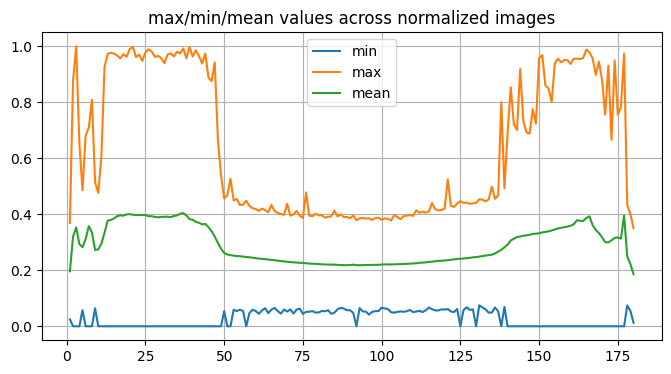

In [9]:
min_value = np.min(projections)
max_value = np.max(projections)
norm_projections = (projections - min_value) / (max_value - min_value)
plot_statistics(norm_projections, 'normalized images')

In [10]:
norm_projections.shape

(180, 1024, 1024)

Show sample projections.

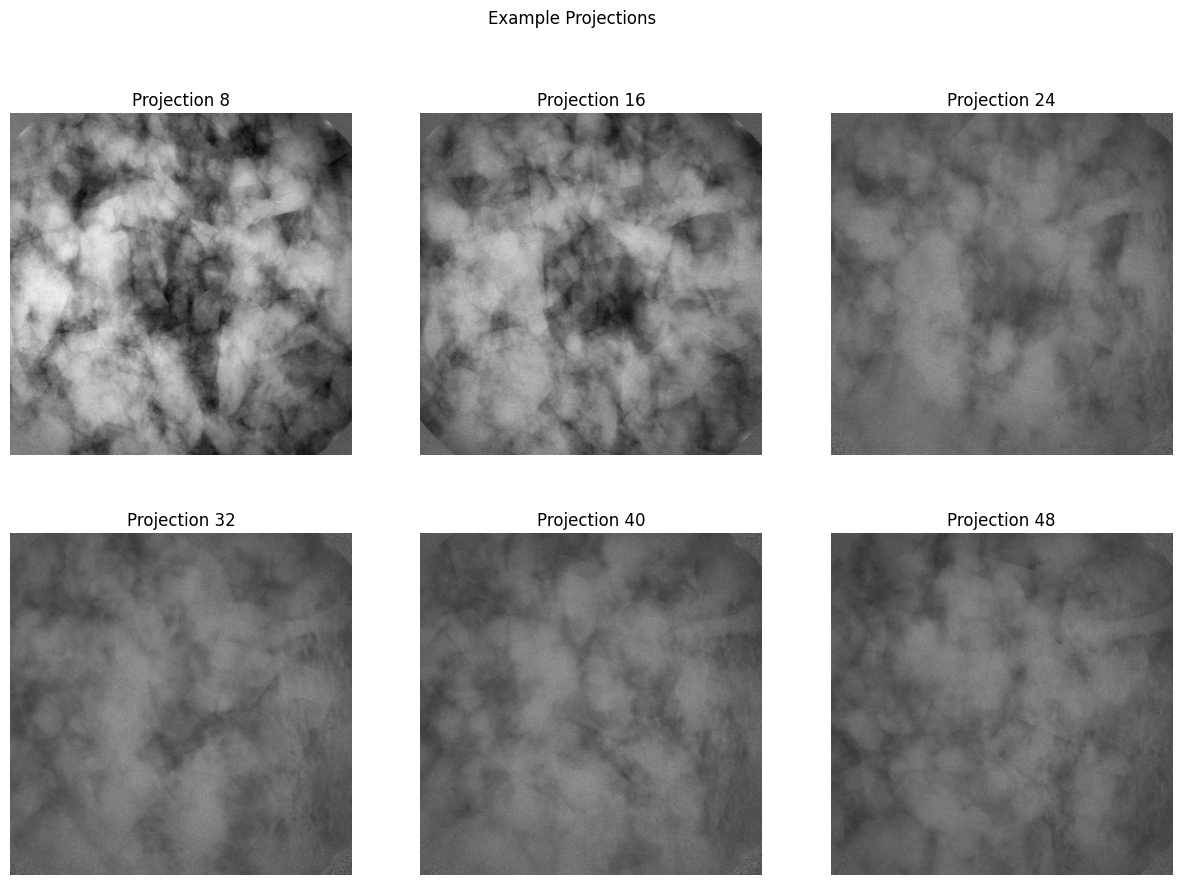

In [11]:
def show_samples(projections):
    skip_every = 8

    plt.figure(figsize=(15, 10))
    for i in range(6):
        plt.subplot(2, 3, i + 1)
        plt.imshow(projections[skip_every * i], cmap='gray')
        plt.title(f"Projection {skip_every * (i+1)}")
        plt.axis('off')
    plt.suptitle("Example Projections")
    plt.show()

show_samples(projections)

Keep only projections between 50 and 130 because of more regular statistics.

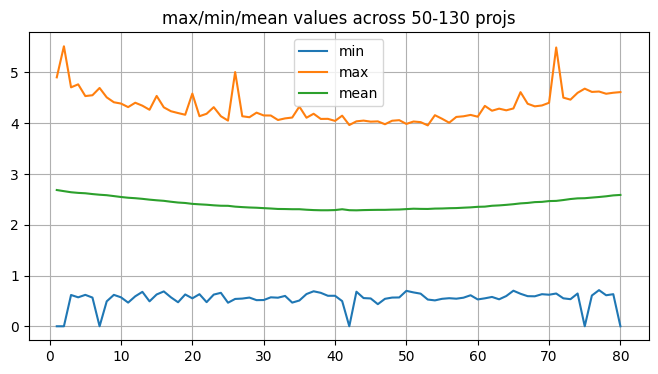

In [26]:
projections_50_130 = projections[50:130]
plot_statistics(projections_50_130, '50-130 projs')

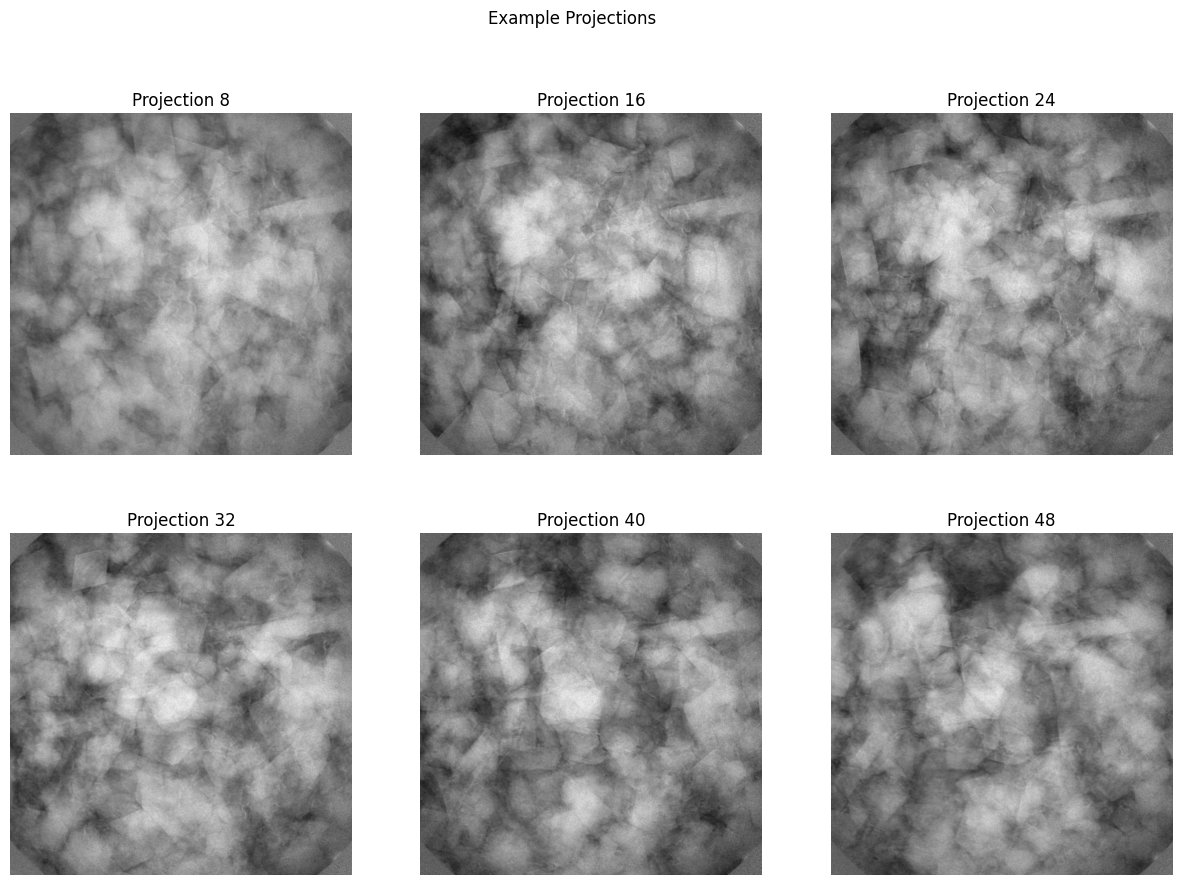

In [27]:
show_samples(projections_50_130)

Normalize projections between 50 and 130.

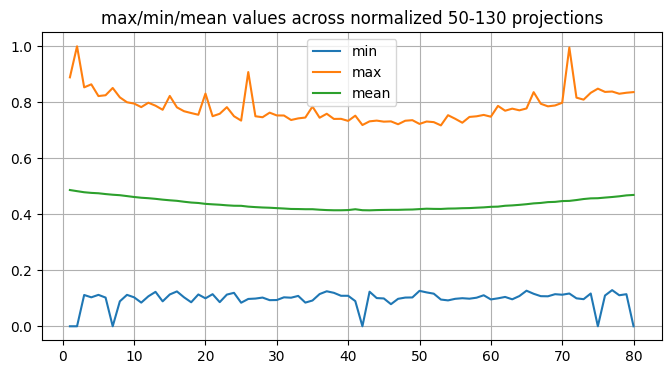

In [28]:
min_value = np.min(projections_50_130)
max_value = np.max(projections_50_130)
norm_projections_50_130 = (projections_50_130 - min_value) / (max_value - min_value)
plot_statistics(norm_projections_50_130, 'normalized 50-130 projections')

Resize to 256x256 and save on disk.

In [7]:
from PIL import Image
output_dir = "data/png/battery_1_180"

for i, projection in enumerate(norm_projections): #norm_projections_50_130
    image = (projection * 255).astype(np.uint8)
    img = Image.fromarray(image)
    img = img.resize((256, 256), Image.Resampling.LANCZOS)

    img_path = os.path.join(output_dir, f"proj{i+1:03d}.png")
    img.save(img_path)

print('Projections saved.')

Projections saved.


Rescale 50-130 projections between high and low threshold. Let's see if the model converges if attenuation values are way smalled than 1.

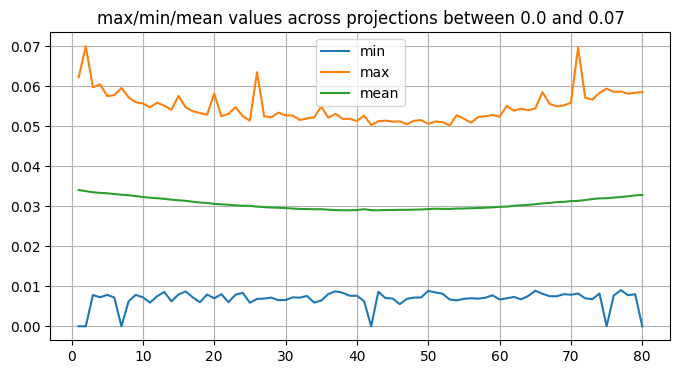

In [30]:
# Target range
target_min = 0.0
target_max = 0.07

rescaled_projections = norm_projections_50_130 * (target_max - target_min) + target_min
plot_statistics(rescaled_projections, f'projections between {target_min} and {target_max}')

In [45]:
np.min(rescaled_projections)
np.max(rescaled_projections)

0.07

And now save to pickle format.

In [41]:
final_projections = np.zeros((80, 256, 256), dtype=rescaled_projections.dtype)

for i in range(final_projections.shape[0]):
    image = Image.fromarray(rescaled_projections[i])
    resized_image = image.resize((256, 256), Image.Resampling.LANCZOS)
    final_projections[i] = np.array(resized_image)

final_projections.shape

(80, 256, 256)

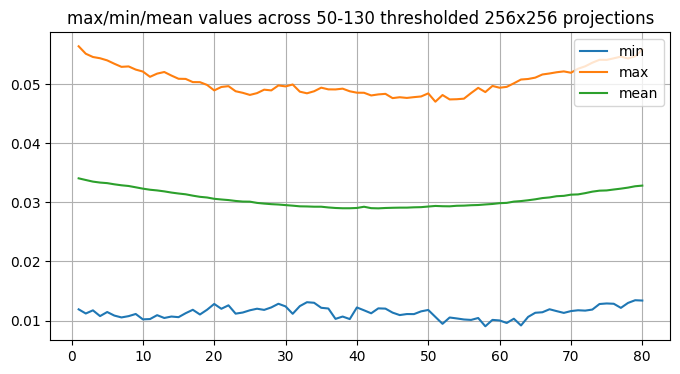

In [46]:
plot_statistics(final_projections, f'50-130 thresholded 256x256 projections')

Computing angles for each projection.

In [47]:
total_angle = 80.0
num_train = 80
start_angle = 0.0

angles = np.linspace(0, total_angle / 180 * np.pi, num_train+1)[:-1] + start_angle/ 180 * np.pi
angles.shape

(80,)

In [48]:
print(np.min(final_projections))
print(np.max(final_projections))

0.0090429885
0.05639705


In [51]:
import pickle

pickle_dict = {
    "numTrain": 80,                # my train projections
    "numVal": 80,                  # we test on the same train projections
    "DSD": 1500.0,
    "DSO": 1000.0,
    "nDetector": [256, 256],        # image size
    "dDetector": [1.0, 1.0],        # pixel size
    "nVoxel": [256, 256, 256],
    "dVoxel": [1.0, 1.0, 1.0],    
    "offOrigin": [0, 0, 0],
    "offDetector": [0, 0],
    "accuracy": 0.5,
    "mode": "parallel",
    "filter": None,
    "totalAngle": total_angle,
    "startAngle": start_angle,
    "randomAngle": False,
    "convert": True,
    "rescale_slope": 1.0,
    "rescale_intercept": 0.0,
    "normalize": True,
    "noise": 0,
    "image": np.zeros((256, 256, 256)),                # GT volume, if any
    "train": {
        "angles": angles,
        "projections": final_projections
    },
    "val": {
        "angles": angles,
        "projections": final_projections
    }
}

file_path = "data/pickle/battery_50_130.pickle"
with open(file_path, 'wb') as file:
    pickle.dump(pickle_dict, file)

print(f"{file_path} saved!")

data/pickle/battery_50_130.pickle saved!


## Import projections from volume

In [7]:
import os
from PIL import Image
import numpy as np

folder_path = 'data/png/gt_projs_from_volume/'
projs_from_volume = []

for filename in sorted(os.listdir(folder_path)):
    if filename.endswith('.png'):
        img_path = os.path.join(folder_path, filename)
        img = Image.open(img_path).resize((256, 256))
        img_array = np.asarray(img) / 255.0
        projs_from_volume.append(img_array)

projs_from_volume = np.stack(projs_from_volume, axis=0)
projs_from_volume.shape

(50, 256, 256)

In [8]:
np.linspace(0, np.pi, projs_from_volume.shape[0]+1)[:-1]

array([0.        , 0.06283185, 0.12566371, 0.18849556, 0.25132741,
       0.31415927, 0.37699112, 0.43982297, 0.50265482, 0.56548668,
       0.62831853, 0.69115038, 0.75398224, 0.81681409, 0.87964594,
       0.9424778 , 1.00530965, 1.0681415 , 1.13097336, 1.19380521,
       1.25663706, 1.31946891, 1.38230077, 1.44513262, 1.50796447,
       1.57079633, 1.63362818, 1.69646003, 1.75929189, 1.82212374,
       1.88495559, 1.94778745, 2.0106193 , 2.07345115, 2.136283  ,
       2.19911486, 2.26194671, 2.32477856, 2.38761042, 2.45044227,
       2.51327412, 2.57610598, 2.63893783, 2.70176968, 2.76460154,
       2.82743339, 2.89026524, 2.95309709, 3.01592895, 3.0787608 ])

In [28]:
angles = np.linspace(0, np.pi, projs_from_volume.shape[0]+1)[:-1]

save_dir = "data/npz"
filename = "projs_angles_from_volume.npz"
np.savez(os.path.join(save_dir, filename), projs=projs_from_volume, angles=angles)

print(f"Saved projections and angles to {save_dir}/{filename}")

Saved projections and angles to data/npz/projs_angles_from_volume.npz


In [29]:
angles.shape

(50,)

## Save to JPG
We fetch the raw data, normalize, resize to 256x256, save to disk

In [9]:
output_images = []

for idx in tqdm(range(num_images)):
    img_data = images[idx].copy()
    
    # Normalize, scale, convert to uint8
    img_data = (img_data - img_data.min()) / (img_data.ptp() + 1e-8)
    img_data = img_data * 255
    img_data = img_data.astype(np.uint8)

    # Convert to PIL image, resize to 256x256, add to list
    img = Image.fromarray(img_data)
    img_resized = img.resize(new_size, Image.LANCZOS)
    output_images.append(np.array(img_resized))
    
    # Save to disk
    output_filename = f"idx_{idx + 1:04d}.jpg"
    output_path = os.path.join(output_folder, output_filename)
    img_resized.save(output_path)

print(f"{len(output_images)} images saved in {output_folder}.")
output_images = np.array(output_images)
print(f'shape: {output_images.shape}')
print(f'min: {output_images.min()}')
print(f'max: {output_images.max()}')


100%|██████████| 180/180 [00:01<00:00, 97.38it/s] 

180 images saved in data/jpg/021_sinograms.
shape: (180, 256, 256)
min: 2
max: 243


## Normalize
Here we normalize between 0-1 and reshape to 256x256.

In [10]:
normalized_images = []

for idx in range(num_images):
    img_data = images[idx].copy()

    # Normalize
    img_data = (img_data - img_data.min()) / (img_data.ptp() + 1e-8)

    # Convert to PIL image, resize to 256x256, add to list
    img = Image.fromarray(img_data)
    img_resized = img.resize(new_size, Image.LANCZOS)
    normalized_images.append(np.array(img_resized))

print(f"{len(normalized_images)} images have been normalized.")
normalized_images = np.array(normalized_images)
print(f'shape: {normalized_images.shape}')
print(f'min: {normalized_images.min()}')
print(f'max: {normalized_images.max()}')

180 images have been normalized.
shape: (180, 256, 256)
min: 0.009282737039029598
max: 0.9556062817573547


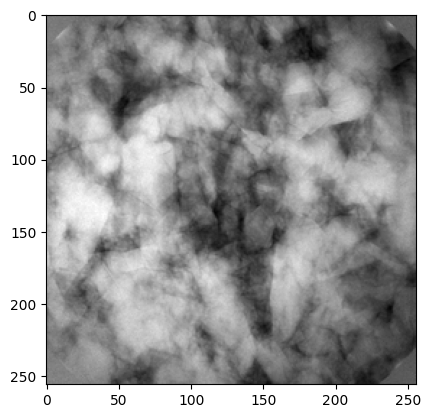

In [11]:
plt.imshow(normalized_images[0], cmap='gray')
plt.show()

We now generate the set of corresponding angles and pack them with the projections in a `npz` file.

In [21]:
angles = np.linspace(0, np.pi, num_images+1)[:-1]

save_dir = "data/npz"
filename = "sinograms_projs_angles.npz"
np.savez(os.path.join(save_dir, filename), projs=normalized_images, angles=angles)

print(f"Saved projections and angles to {save_dir}/{filename}")

Saved projections and angles to data/npz/sinograms_projs_angles.npz


In [23]:
angles.shape

(180,)